##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [41]:
!pip install torch

In [42]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [43]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [44]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [45]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [46]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [47]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [48]:
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


* X - latitude
* Y - longitude
* Area_Command - The police designation of the bureau of the operation
* NIBRSOffenseCode - Classification code for the crime committed
* DayOfWeek - Day of the week
* Time - Hour of the day
* VictimCount - number of persons involved in the accident
* Input Variables - X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek, Time
* Target Variables - VictimCount

* Input Variables - X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek, Time
* Target Variables - VictimCount

In [49]:
min_values = df.min()
max_values = df.max()
print('Minimum Values: ')
print(min_values)
print('')
print('Maximun Values: ')
print(max_values)

Minimum Values: 
X                  -116.000000
Y                    35.068419
Area_Command          0.000000
NIBRSOffenseCode      0.000000
DayOfWeek             0.000000
Time                  0.000000
VictimCount           0.000000
dtype: float64

Maximun Values: 
X                  -114.62557
Y                    37.00000
Area_Command         11.00000
NIBRSOffenseCode      2.00000
DayOfWeek             6.00000
Time                 23.00000
VictimCount           6.00000
dtype: float64


* data does not require scaling or normalization, as the range of values in each column is already within a reasonable range (e.g., latitude and longitude are within the expected geographical bounds, and other values are within their respective expected ranges).

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [50]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx].values
        if self.transform:
            sample = self.transform(sample)
        return sample

# Define your dataset
dataset = CustomDataset(df)

# Define the split between training and testing data
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Define DataLoader objects for training and testing
batch_size = 64  # You can choose a reasonable batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Iterate over one dataset and print the shape of the batched data
for batch in train_loader:
    # The shape of the batched data
    print("Batch shape:", batch.shape)

Batch shape: torch.Size([64, 7])
Batch shape: torch.Size([64, 7])
Batch shape: torch.Size([64, 7])
Batch shape: torch.Size([28, 7])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
# Define your neural network for regression
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)  # Output size is 1 for regression

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define your loss function for regression (Mean Squared Error)
criterion = nn.MSELoss()

# Define your dataset and DataLoader
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['VictimCount']), df['VictimCount'], test_size=0.2, random_state=42)

class RegressionDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data.iloc[idx], dtype=torch.float32)
        y = torch.tensor(self.target.iloc[idx], dtype=torch.float32)
        return x, y

batch_size = 32

train_dataset = RegressionDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = RegressionDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define your model
input_size = len(X_train.columns)
hidden_size = 64
model = RegressionModel(input_size, hidden_size)

# Define your optimizer (e.g., Adam)
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}: Loss: {avg_loss:.4f}")

# Calculate Mean Squared Error (MSE) on the test data and print it
model.eval()
total_test_loss = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        predictions = model(inputs)
        test_loss = criterion(predictions, targets)
        total_test_loss += test_loss.item()
    avg_test_loss = total_test_loss / len(test_loader)
    print(f"Test MSE: {avg_test_loss:.4f}")

/Users/srujanathummala/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/srujanathummala/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10: Loss: 28.8188
Epoch 2/10: Loss: 3.5117
Epoch 3/10: Loss: 6.7265
Epoch 4/10: Loss: 2.0663
Epoch 5/10: Loss: 2.3125
Epoch 6/10: Loss: 1.6986
Epoch 7/10: Loss: 1.3966
Epoch 8/10: Loss: 1.3893
Epoch 9/10: Loss: 1.3272
Epoch 10/10: Loss: 1.2529
Test MSE: 1.1369


/Users/srujanathummala/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Define your neural network for classification
class CrimeClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CrimeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Determine the number of classes based on your data
num_classes = len(df['VictimCount'].unique())

# Define the model, loss function, and optimizer
input_size = len(X_train.columns)
model = CrimeClassifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()

    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / len(train_dataset)  # Training accuracy

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f} - Training Accuracy: {accuracy:.4f}")

    # Testing the model
    model.eval()
    correct_predictions = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()

        test_accuracy = correct_predictions / len(test_dataset)
        print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch [1/20] - Loss: 7.2861 - Training Accuracy: 0.3682
Test Accuracy: 0.5455
Epoch [2/20] - Loss: 2.6322 - Training Accuracy: 0.5091
Test Accuracy: 0.3091
Epoch [3/20] - Loss: 1.9231 - Training Accuracy: 0.3091
Test Accuracy: 0.3091
Epoch [4/20] - Loss: 1.6072 - Training Accuracy: 0.4227
Test Accuracy: 0.5455
Epoch [5/20] - Loss: 1.3622 - Training Accuracy: 0.5000
Test Accuracy: 0.2909
Epoch [6/20] - Loss: 1.2433 - Training Accuracy: 0.4818
Test Accuracy: 0.5455
Epoch [7/20] - Loss: 1.2234 - Training Accuracy: 0.4955
Test Accuracy: 0.2909
Epoch [8/20] - Loss: 1.1565 - Training Accuracy: 0.5409
Test Accuracy: 0.5455
Epoch [9/20] - Loss: 1.1621 - Training Accuracy: 0.4818
Test Accuracy: 0.2182
Epoch [10/20] - Loss: 1.1645 - Training Accuracy: 0.4591
Test Accuracy: 0.5455
Epoch [11/20] - Loss: 1.1100 - Training Accuracy: 0.5045
Test Accuracy: 0.3818
Epoch [12/20] - Loss: 1.1611 - Training Accuracy: 0.4955
Test Accuracy: 0.4727
Epoch [13/20] - Loss: 1.1107 - Training Accuracy: 0.4909
Test

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

In [53]:
for inputs, targets in test_loader:
    predictions = model(inputs)
    misclassified = (predictions.argmax(1) != targets).nonzero().squeeze().tolist()
    if misclassified:
        misclassified_example = misclassified[0]
        print(f"Misclassified Example: Predicted - {predictions[misclassified_example].argmax()}, Actual - {targets[misclassified_example]}")
        # Calculate class probabilities using softmax and plot them in a bar chart
        class_probs = torch.softmax(predictions[misclassified_example], dim=0)
        print(f"Class Probabilities: {class_probs}")

Misclassified Example: Predicted - 1, Actual - 0.0
Class Probabilities: tensor([0.4157, 0.4917, 0.0262, 0.0542, 0.0030, 0.0038, 0.0054],
       grad_fn=<SoftmaxBackward0>)
Misclassified Example: Predicted - 0, Actual - 1.0
Class Probabilities: tensor([0.4873, 0.4188, 0.0197, 0.0606, 0.0030, 0.0038, 0.0068],
       grad_fn=<SoftmaxBackward0>)


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


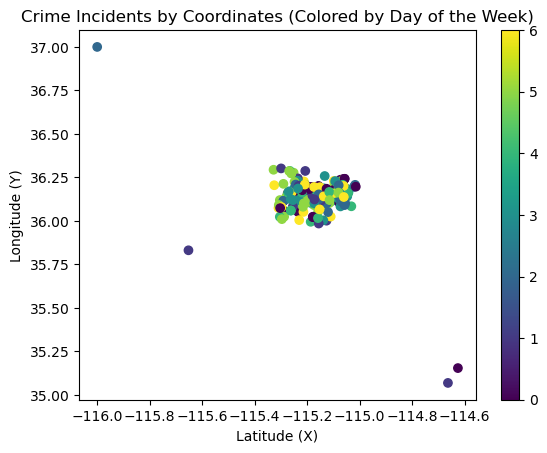

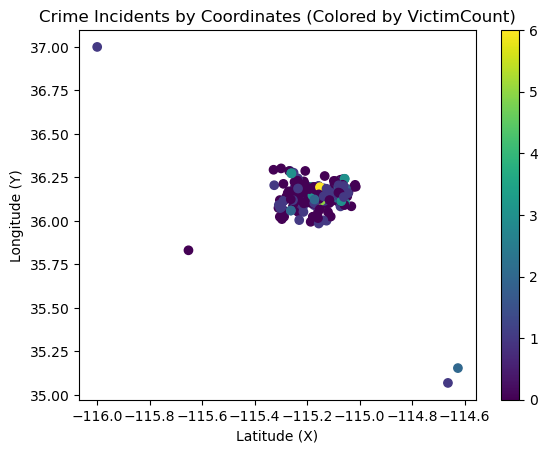

Number of Crimes by Day of the Week:
DayOfWeek
0    40
1    37
2    32
3    44
4    51
5    43
6    28
Name: count, dtype: int64


In [54]:
import matplotlib.pyplot as plt
# 1. Plot the crime incidents as a scatter plot using coordinates, indicating the day of the week with colors
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis')
plt.title("Crime Incidents by Coordinates (Colored by Day of the Week)")
plt.xlabel("Latitude (X)")
plt.ylabel("Longitude (Y)")
plt.colorbar()
plt.show()

# 2. Scatter plot with coordinates, indicating the number of persons involved with colors
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis')
plt.title("Crime Incidents by Coordinates (Colored by VictimCount)")
plt.xlabel("Latitude (X)")
plt.ylabel("Longitude (Y)")
plt.colorbar()
plt.show()

# 3. Sort the number of crimes reported by the day of the week
day_of_week_counts = df['DayOfWeek'].value_counts().sort_index()
print("Number of Crimes by Day of the Week:")
print(day_of_week_counts)
